In [1]:
from music21 import corpus
# Now try training on more bach
paths = corpus.getComposer('bach')
len(paths)

433

In [2]:
paths[:5]

[PosixPath('/Users/kdr/.pyenv/versions/3.12.8/envs/default/lib/python3.12/site-packages/music21/corpus/bach/bwv1.6.mxl'),
 PosixPath('/Users/kdr/.pyenv/versions/3.12.8/envs/default/lib/python3.12/site-packages/music21/corpus/bach/bwv10.7.mxl'),
 PosixPath('/Users/kdr/.pyenv/versions/3.12.8/envs/default/lib/python3.12/site-packages/music21/corpus/bach/bwv101.7.mxl'),
 PosixPath('/Users/kdr/.pyenv/versions/3.12.8/envs/default/lib/python3.12/site-packages/music21/corpus/bach/bwv102.7.mxl'),
 PosixPath('/Users/kdr/.pyenv/versions/3.12.8/envs/default/lib/python3.12/site-packages/music21/corpus/bach/bwv103.6.mxl')]

In [22]:
from tqdm import tqdm
from music21 import corpus, metadata, note, stream

all_states = set()
all_pitches = set()
all_durations = set()
training_data = []
chord_occurence_count = 0
note_count = 0
for p in tqdm(paths):
    # Load the score
    s = corpus.parse(p)
    
    soprano_part = None
    for part in s.parts:
        if "Soprano" in (part.partName or ""):  # Check for 'Soprano' in the part name
            soprano_part = part
            break
    
    # Fallback if no explicit Soprano part is named
    if soprano_part is None:
        # Assume the first part is the Soprano if no explicit naming is found
        soprano_part = s.parts[0]
    
    # Extract notes and rests (pitch and duration)
    notes_sequence = []
    for element in soprano_part.flat.notesAndRests:  # Include notes and rests
        if element.isNote:
            notes_sequence.append((element.pitch.nameWithOctave, element.quarterLength))
        elif element.isChord:        
            # If there's a chord, take the highest note (melodic line usually uses the top note)
            #notes_sequence.append((element.highestNote.nameWithOctave, element.quarterLength))

            # Get the bass (lowest) note of the chord
            bass_note = element.bass()
            notes_sequence.append((bass_note.nameWithOctave, element.quarterLength))

            chord_occurence_count += 1
        elif element.isRest:
            notes_sequence.append(('Rest', element.quarterLength))

    notes = []
    for pitch, duration in notes_sequence:    
        all_pitches.add(pitch)
        all_durations.add(duration)
        s = (pitch, duration)
        if pitch == 'Rest':
            notes.append(note.Rest(quarterLength=s[1]))
            #ignore rests for now
            #pass
        else:
            notes.append(note.Note(s[0], quarterLength=s[1]))        
        all_states.add(s)    
    training_data.append(notes)
    note_count += len(notes)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 433/433 [00:07<00:00, 57.78it/s]


In [26]:
22879/23338 # percent non rest

0.980332504927586

In [23]:
note_count, chord_occurence_count, len(training_data)

(23338, 1156, 433)

In [27]:
len(all_states)

212

In [28]:
len(all_pitches)

41

In [29]:
print(sorted(all_pitches))

['A#4', 'A#5', 'A-4', 'A-5', 'A3', 'A4', 'A5', 'B#4', 'B-3', 'B-4', 'B3', 'B4', 'C#4', 'C#5', 'C4', 'C5', 'D#4', 'D#5', 'D-5', 'D3', 'D4', 'D5', 'E#4', 'E#5', 'E-4', 'E-5', 'E4', 'E5', 'F#4', 'F#5', 'F3', 'F4', 'F5', 'G#4', 'G#5', 'G-4', 'G-5', 'G3', 'G4', 'G5', 'Rest']


In [30]:
len(all_durations)

12

In [31]:
all_durations

{0.0, 0.125, 0.25, 0.5, 0.75, 1.0, 1.5, 2.0, 3.0, 4.0, 6.0, 8.0}

In [32]:
from simplemelodygen.extensions import MultiInstanceTrainableMarkovChainMelodyGenerator
model = MultiInstanceTrainableMarkovChainMelodyGenerator(list(all_states))

In [33]:
%%time
model.train(training_data)

CPU times: user 65.3 ms, sys: 2.02 ms, total: 67.3 ms
Wall time: 66.7 ms


In [39]:
%%time
generated_melody = model.generate(30)

CPU times: user 2.48 ms, sys: 988 μs, total: 3.46 ms
Wall time: 3.02 ms


In [40]:
from music21 import metadata, note, stream

score = stream.Score()
score.metadata = metadata.Metadata(title="Markov Chain Melody - Random Bach II")
part = stream.Part()
for n, d in generated_melody:
    if n == 'Rest':
        part.append(note.Rest(quarterLength=d))    
    else:
        part.append(note.Note(n, quarterLength=d))
score.append(part)

In [41]:
score.show('midi')

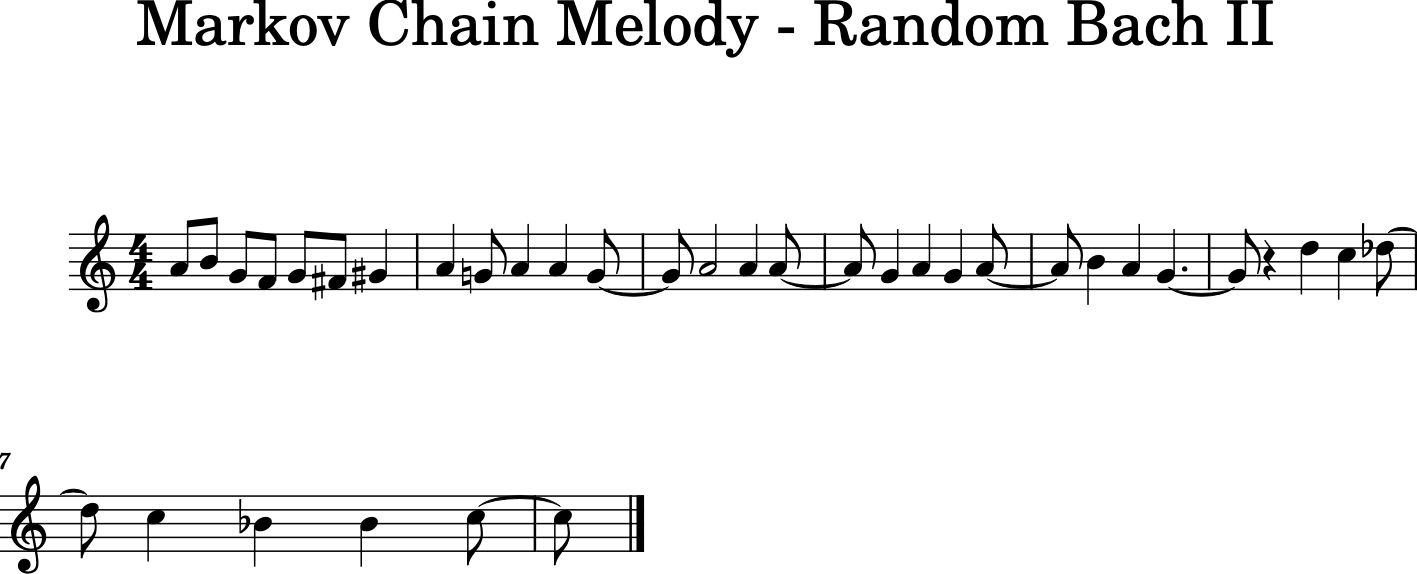

In [42]:
score.show()